## ИПР 6.  Метод конечных элементов для уравнения Пуассона.

#### Шаг 1. Постройте сеть:

**Подключение необходимых библиотек:**

In [1]:
from scipy.sparse.lil import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.interpolate import griddata
import meshpy.triangle as triangle
import matplotlib.pyplot as plt
import numpy.linalg as la
import pandas as pd
import numpy as np
import math

**Функции для построения мешей:**

In [2]:
roundof = lambda start, end: [(i, i + 1) for i in range(start, end)] + [(end, start)]

def grid_builder(): # Обычная сетка без дырки
    points = list()
    points.extend((math.cos(angle),  math.sin(angle)) for angle in np.linspace(0, 2 * math.pi, 1000, endpoint=False))

    info = triangle.MeshInfo()
    info.set_facets(roundof(0, len(points)-1))
    info.set_points(points)
    
    mesh = triangle.build(info, max_volume=1e-2, min_angle=15)
    mesh_points = np.array(mesh.points)
    mesh_tris = np.array(mesh.elements)
    mesh_facets = np.array(mesh.facets)
    return mesh_points, mesh_tris, mesh_facets

def hole_grid(eps): # Сетка с дыркой
    points = list()
    points.extend((0.3 * math.cos(angle) + 0.7 - eps, 0.3 * math.sin(angle)) for angle in np.linspace(0, 2 * math.pi, 1000, endpoint=False))
    facets = roundof(0, len(points) - 1)

    circ_start = len(points)
    points.extend(
            (1 * math.cos(angle), 1 * math.sin(angle))
            for angle in np.linspace(0, 2 * math.pi, 1000, endpoint=False))

    facets.extend(roundof(circ_start, len(points)-1))

    info = triangle.MeshInfo()
    info.set_holes([(0.7, 0)])
    info.set_facets(facets)
    info.set_points(points)
    mesh = triangle.build(info, max_volume=6e-3) 

    mesh_facets = np.array(mesh.facets)
    mesh_points = np.array(mesh.points)
    mesh_tris = np.array(mesh.elements)
    return mesh_points, mesh_tris, mesh_facets

def show_grid(mesh_tris, mesh_points):
    plt.figure(figsize=(10, 10))
    out = [mesh_tris.shape[0],mesh_points,mesh_tris]
    plt.triplot(mesh_points[:, 0], mesh_points[:, 1], mesh_tris)
    plt.show()

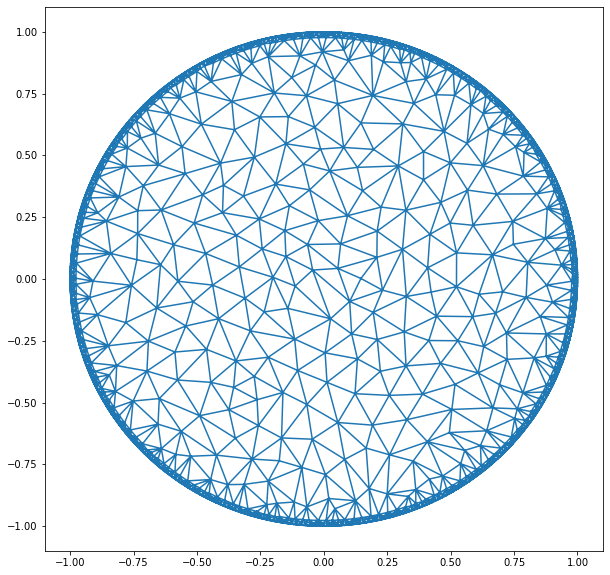

In [3]:
mesh_points, mesh_tris, mesh_facets = grid_builder()
show_grid(mesh_tris, mesh_points)

#### Шаг 2. Составьте матрицу жесткости:
* Напишите функцию, которая составляет $3\times 3$ матрицу $M$ для заданного треугольника
$$M = \frac{|T|}{2} G G^T,
\qquad\text{где}\qquad
G =
\left(
\begin{array}{ccc}
1 & 1 & 1 \\
x_1 & x_2 & x_3 \\
y_1 & y_2 & y_3
\end{array}
\right)^{-1}
\left(
\begin{array}{ccc}
0 & 0 \\
1 & 0 \\
0 & 1
\end{array}
\right),
$$
и |T| - площадь треугольника:
$$
2 |T| = \det \left(
\begin{array}{cc}
x _2 - x _1 & y _2 - y _1 \\
x _3 - x _1 & y _3 - y _1 \\
\end{array}
\right),
$$
* В цикле по всем треугольникам соберите матрицу жеcткости.

* Поправьте строки и столбцы, соответствующие условию Дирихле

**Примечание:** используйте $\verb|scipy.sparse|$ для работы с разреженными матрицами. Обратите внимание, что lil - это единственный формат $\verb|scipy.sparse|$ который позволяет менять элементы разреженной матрицы после создания.

In [4]:
def stiffness_matrix(tris, points, facets):  # Составляем матрицу жёсткости
    result_matrix = lil_matrix((len(points), len(points)))
    for tr in tris:
        matrix = get_matrix(tr, points)
        for k in range(3):
            for l in range(3):
                result_matrix[tr[k], tr[l]] += matrix[k, l]
    for p in facets[:, 0]:
        result_matrix[p, :] = result_matrix[:, p] = 0
        result_matrix[p, p] = 1
    return result_matrix

def get_matrix(triangle, points):
    p1, p2, p3 = (points[i] for i in triangle)
    S = area((p1, p2, p3))
    G = la.inv(np.array([[1, 1, 1], [p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]]])).dot(np.array([[0, 0], [1, 0], [0, 1]]))
    return np.matmul(S * G, G.T)

def area(points):  # Площадь треугольника
    p1, p2, p3 = points
    return la.det(np.array([[p2[0] - p1[0], p2[1] - p1[1]], [p3[0] - p1[0], p3[1] - p1[1]]])) / 2

In [5]:
matrix = stiffness_matrix(mesh_tris, mesh_points, mesh_facets)

#### Шаг 3. Создайте правую часть уравнения:
Правая часть уравнения для $i$-го узла сети: $$f_i = \int_\Omega f \eta_i d\Omega .$$
Чтобы собрать правую часть пройдите все узлы в цикле и посчитайте $$ \int_T f \eta_i.$$ Можно использовать апроксимацию $$ \int_T f \eta_i \approx f(x_S, y_S) \int_\Omega \eta_i, $$ где $(x_S,y_S)$ обозначает центр масс треугольника.

In [6]:
def right_part_equation(tris, points, facets):
    f = np.zeros(len(points))
    for tr in tris:
        p1, p2, p3 = (points[i] for i in tr)
        for j in range(3):
            f[tr[j]] += 1 / 3 * area((p1, p2, p3))
    return f

In [7]:
f = right_part_equation(mesh_tris, mesh_points, mesh_facets)

#### Шаг 4. Проверьте свой код:

In [8]:
def plot_speed(points, sol):
    x = np.linspace(-1, 1, 1000) 
    y = np.linspace(-1, 1, 1000)
    z = griddata((points[:, 0], points[:, 1]), sol, tuple(np.meshgrid(x, y)))
    plt.figure(figsize=(11, 10))
    plt.contourf(x, y, z, cmap="ocean_r")
    plt.colorbar()
    plt.title("Распределение скорости жидкости", size=20)
    plt.show()
    
def new_plot_speed(points, sol):
    x = np.linspace(-1, 1, 1000) 
    y = np.linspace(-1, 1, 1000)
    z = griddata((points[:, 0], points[:, 1]), (1 - points[:, 0]**2 - points[:, 1]**2)/4, tuple(np.meshgrid(x, y)))
    plt.figure(figsize=(11, 10))
    plt.contourf(x, y, z, cmap="ocean_r")
    plt.colorbar()
    plt.title("Распределение скорости жидкости", size=20)
    plt.show()
    
def diff_plot(points, sol):
    x = np.linspace(-1, 1, 1000) 
    y = np.linspace(-1, 1, 1000)
    z = griddata((points[:, 0], points[:, 1]), ((1 - points[:, 0]**2 - points[:, 1]**2)/4) - sol, tuple(np.meshgrid(x, y)))
    plt.figure(figsize=(11, 10))
    plt.contourf(x, y, z, cmap="ocean_r")
    plt.colorbar()
    plt.title("Распределение скорости жидкости", size=20)
    plt.show()

#### Решение:

In [9]:
solve = spsolve(matrix, f)

c:\users\andre\appdata\local\programs\python\python36-32\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


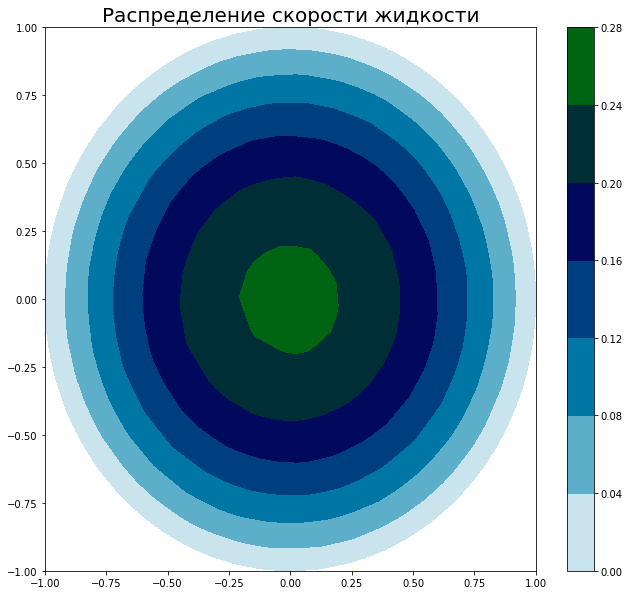

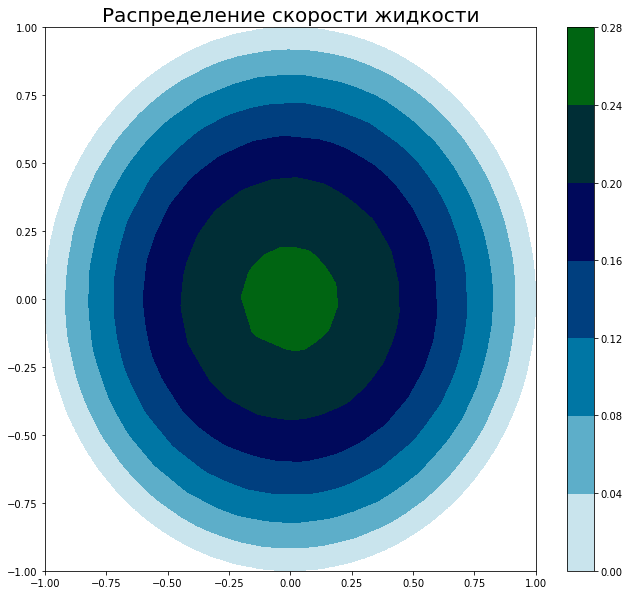

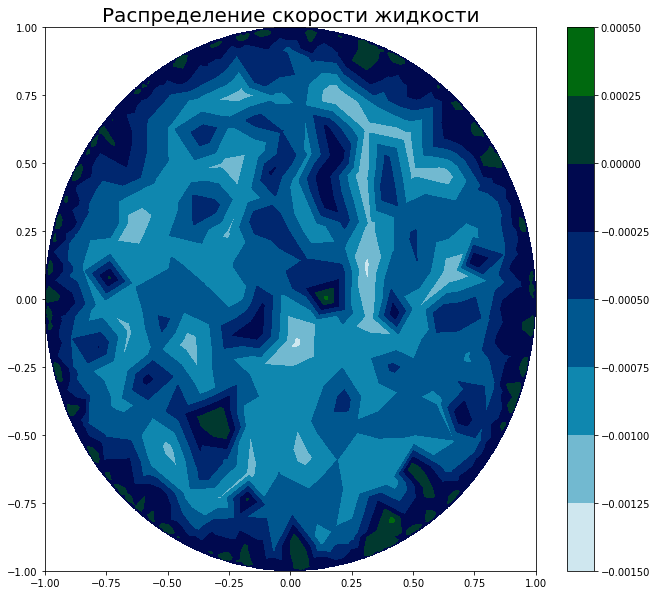

In [10]:
plot_speed(mesh_points, solve)
new_plot_speed(mesh_points, solve)
diff_plot(mesh_points, solve)

#### Шаг 5. Решите задачу для заданного региона:

Рассмотрите регионы $\Omega_1 = B_1(0,0)\setminus B_{0.3}(0.7-2\epsilon,0)$ и $\Omega_2 = B_1(0,0)\setminus B_{0.3}(0.7-\epsilon,0)$ и покажите что полученные решения (или интегралы решений) близки друг к другу для малых $\epsilon$.

**Задаём функцции и E:**

In [11]:
eps = 1e-5

def fluid_flow(tris, points, sol):
    result = 0
    for tr in tris:
        (p1, h1), (p2, h2), (p3, h3) = ((points[i], sol[i]) for i in tr)
        result += area((p1, p2, p3)) * (h1 + h2 + h3) / 3
    return result

def solve(points, tris, facets):
    matrix = stiffness_matrix(tris, points, facets)
    f = right_part_equation(tris, points, facets)
    return spsolve(matrix, f)

$\Omega_1$

In [12]:
points1, tris1, facets1 = hole_grid(eps)
sol1 = solve(points1, tris1, facets1)

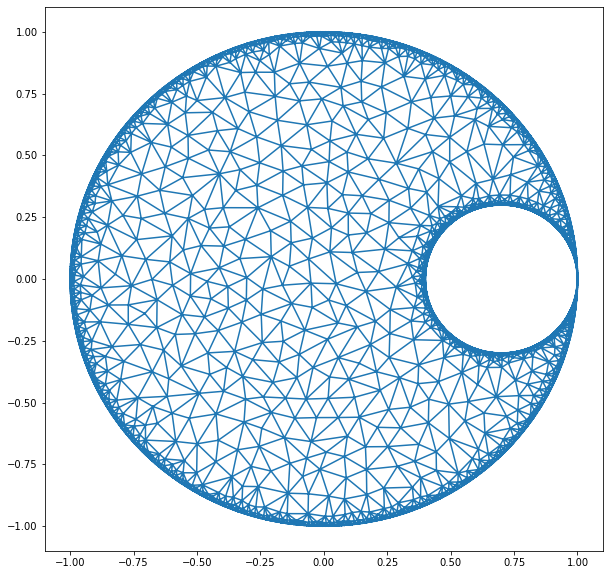

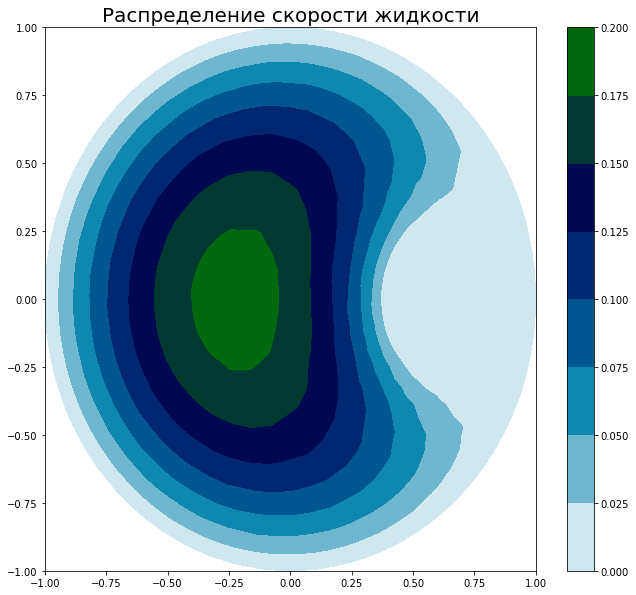

In [13]:
show_grid(tris1, points1)
plot_speed(points1, sol1)

$\Omega_2$

In [14]:
points2, tris2, facets2 = hole_grid(eps*2)
sol2 = solve(points2, tris2, facets2)

In [15]:
fluid_flow(tris1, points1, sol1)

0.2468536712059052

In [16]:
fluid_flow(tris2, points2, sol2)

0.24684983580030279

**Решения довольно близки**

In [17]:
solve1 = []
solve2 = []
solve1_solve2 = []
eps = np.linspace(1e-5, 1e-1, 10)
for i in range(len(eps)):
    points1, tris1, facets1 = hole_grid(eps[i])
    sol1 = solve(points1, tris1, facets1)
    solve1.append(fluid_flow(tris1, points1, sol1))
    points2, tris2, facets2 = hole_grid(eps[i] * 2)
    sol2 = solve(points2, tris2, facets2)
    solve2.append(fluid_flow(tris2, points2, sol2))
    solve1_solve2.append(abs(solve1[i] - solve2[i]))

data = {"eps": eps,
        "solve1": solve1,
        "solve2": solve2,
        "|solve1 - solve2|": solve1_solve2}

print(pd.DataFrame(data))

       eps    solve1    solve2  |solve1 - solve2|
0  0.00001  0.246854  0.246850           0.000004
1  0.01112  0.243515  0.240220           0.003295
2  0.02223  0.240224  0.233439           0.006785
3  0.03334  0.236799  0.226721           0.010078
4  0.04445  0.233443  0.220173           0.013270
5  0.05556  0.230055  0.213749           0.016306
6  0.06667  0.226784  0.207422           0.019361
7  0.07778  0.223528  0.201087           0.022441
8  0.08889  0.220172  0.194996           0.025176
9  0.10000  0.217062  0.189120           0.027942


#### Шаг 6. Посчитайте поток жидкости:

* Посчитайте поток жидкости для области $\int_{\Omega} u\, d \Omega$ in $B_1(0,0)\setminus B_{0.3}(0.7,0)$ и $B_1(0,0)\setminus B_{0.3}(0.5,0)$. Какой из них больше?

**Примечание:** $\int_{\Omega} u\, d \Omega$ не просто сумма всех элементов вектора решения, так как $u(x,y) \approx \sum с_i \eta_i(x,y)$.

In [18]:
points1, tris1, facets1 = hole_grid(1e-4) # ~0.7
sol1 = solve(points1, tris1, facets1)

$\int_{\Omega_1}u_1\, d \Omega$:

In [19]:
fluid_flow(tris1, points1, sol1)

0.24693628581821844

In [20]:
points2, tris2, facets2 = hole_grid(0.2) # 0.5
sol2 = solve(points2, tris2, facets2)

$B_1(0,0)\setminus B_{0.3}(0.5,0)$.

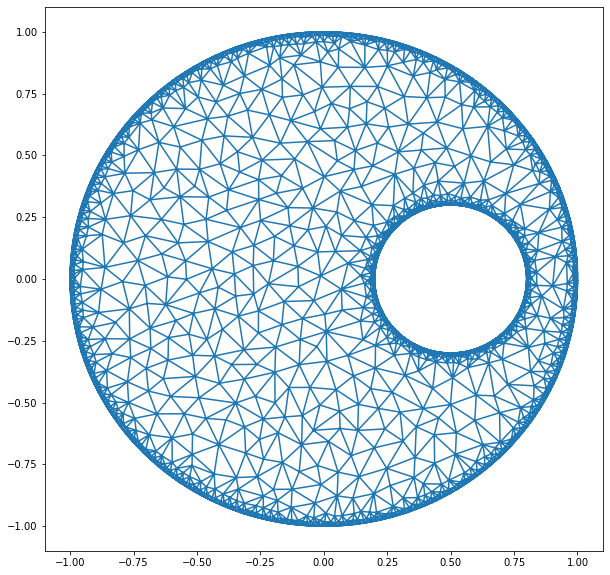

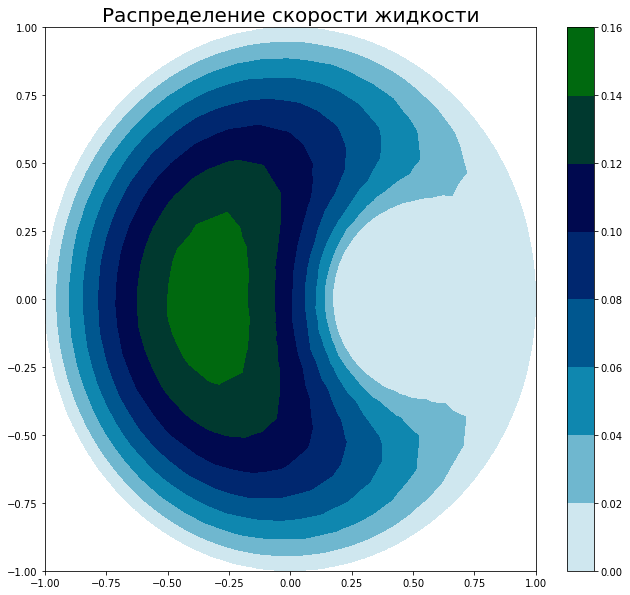

In [21]:
show_grid(tris2, points2)
plot_speed(points2, sol2)

$\int_{\Omega_2}u_2\, d \Omega$:

In [22]:
fluid_flow(tris2, points2, sol2)

0.1891202002229525

Поток жидкости в первом случае больше чем во втором